In [1]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr

from sdm_eurec4a.visulization import set_custom_rcParams, symlog_from_array
from sdm_eurec4a.identifications import select_individual_cloud, match_clouds_and_cloudcomposite, match_clouds_and_dropsondes
from sdm_eurec4a.reductions import x_y_flatten
from sdm_eurec4a.pySD import probdists

from sdm_eurec4a.conversions import msd_from_psd

In [2]:
plt.style.use("default")
default_colors = set_custom_rcParams()
from matplotlib import rc

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc("text", usetex=False)

# THE PATH TO THE SCRIPT DIRECTORY
script_dir = os.path.abspath("/home/m/m301096/repositories/sdm-eurec4a/scripts/CLEO/initalize")
print(script_dir)

REPOSITORY_ROOT = Path(script_dir).parents[2]
print(REPOSITORY_ROOT)

fig_path = REPOSITORY_ROOT / Path("results/CLEO/initilization/fitting_psd")
fig_path.mkdir(parents=True, exist_ok=True)

/home/m/m301096/repositories/sdm-eurec4a/scripts/CLEO/initalize
/home/m/m301096/repositories/sdm-eurec4a


### Load datasets

In [3]:
# Load data
mask_name = "cloud_mask"
chosen_id = 1421

subfig_path = fig_path / Path(f"{mask_name}_{chosen_id}")
subfig_path.mkdir(parents=True, exist_ok=True)
# mask_name = "rain_mask"
# chosen_id = 77

identified_clouds = xr.open_dataset(
    REPOSITORY_ROOT
    / Path(
        f"data/observation/cloud_composite/processed/identified_clouds/identified_clouds_{mask_name}.nc"
    )
)
# select only clouds which are between 800 and 1100 m
identified_clouds = identified_clouds.where(
    (identified_clouds.alt >= 800) & (identified_clouds.alt <= 1100), drop=True
)

distance_IC_DS = xr.open_dataset(
    REPOSITORY_ROOT
    / Path(f"data/observation/combined/distance/distance_dropsondes_clouds_{mask_name}.nc")
)

cloud_composite = xr.open_dataset(
    REPOSITORY_ROOT / Path("data/observation/cloud_composite/processed/cloud_composite.nc"),
    chunks={"time": 1000},
)

drop_sondes = xr.open_dataset(
    REPOSITORY_ROOT
    / Path("data/observation/dropsonde/Level_3/EUREC4A_JOANNE_Dropsonde-RD41_Level_3_v2.0.0.nc")
)
drop_sondes = drop_sondes.rename({"launch_time": "time"})
drop_sondes = drop_sondes.swap_dims({"sonde_id": "time"})
drop_sondes = drop_sondes.sortby("time")
drop_sondes = drop_sondes.chunk({"time": -1})

### Use Total number concentration

Chose an individual cloud to handle.
Use ``chosen_id = 77`` for the rain_mask case
Use ``chosen_id = 1421`` for the cloud_mask case

In [4]:
# select a single cloud
ds_cloud = select_individual_cloud(identified_clouds, chosen_id)
ds_sonde = match_clouds_and_dropsondes(
    ds_cloud=ds_cloud,
    ds_sonde=drop_sondes,
    ds_distance=distance_IC_DS,
    max_temporal_distance=np.timedelta64(1, "h"),
    max_spatial_distance=100,
)

ds_cloudcomposite = match_clouds_and_cloudcomposite(
    ds_cloud=ds_cloud,
    ds_cloudcomposite=cloud_composite,
)

# Make sure to have the total number of particles in the cloud See also #28 on GitHub
attrs = ds_cloudcomposite["particle_size_distribution"].attrs
attrs.update({
    "unit": "#/L",
    "comment": "histogram: each bin gives the number of droplets per liter of air, NOT normalized by the bin width", 
    })
ds_cloudcomposite["particle_size_distribution"] = ds_cloudcomposite['particle_size_distribution'] * ds_cloudcomposite["bin_width"]
ds_cloudcomposite["particle_size_distribution"].attrs = attrs

#### Plot the distributions in linear and lognormal space

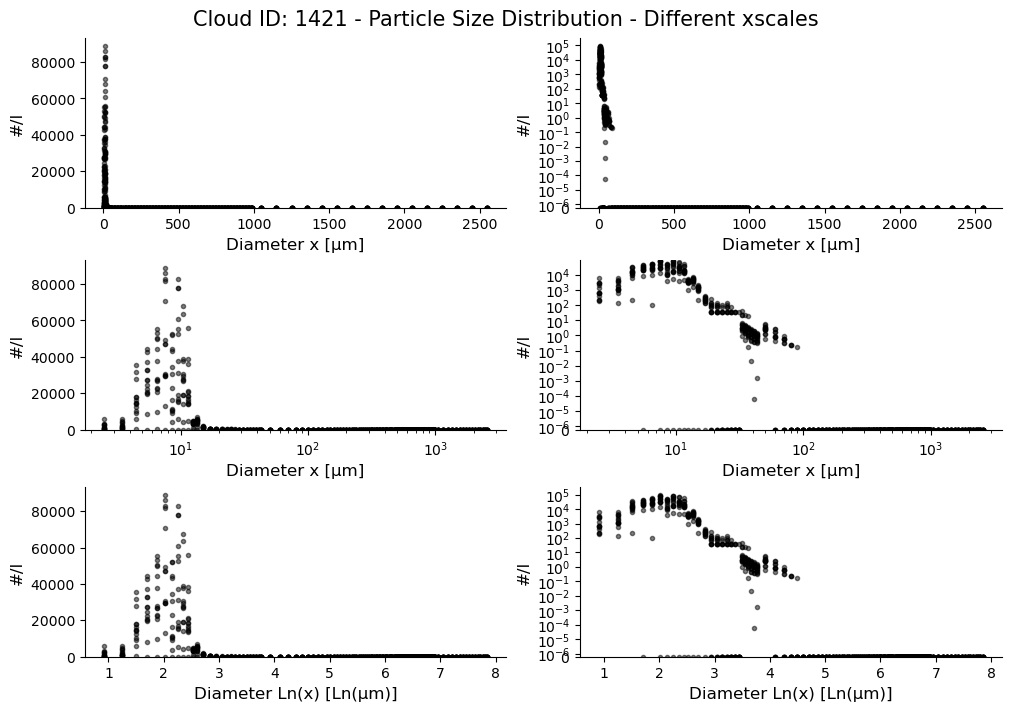

In [5]:
style = dict(
    marker=".",
    linestyle="none",
    color="k",
    alpha=0.5,
)
psd = ds_cloudcomposite["particle_size_distribution"]
symlog = symlog_from_array(psd)

fig, axss = plt.subplots(3, 2, figsize=(10, 7), layout="constrained")


fig.suptitle(f"Cloud ID: {chosen_id} - Particle Size Distribution - Different xscales")

for axs in axss.T:
    axs[0].plot(
        psd["diameter"],
        psd,
        **style,
    )
    # axs[0].set_title("Linear of x")
    axs[0].set_xlabel("Diameter x [µm]")
    axs[0].set_ylabel("Counts [#/l]")
    axs[1].plot(
        psd["diameter"],
        psd,
        **style,
    )
    axs[1].set_xscale("log")
    # axs[1].set_title("Linear of x on log10 scale")
    axs[1].set_xlabel("Diameter x [µm]")
    axs[1].set_ylabel("Counts [#/l]")

    axs[2].plot(
        np.log(psd["diameter"]),
        psd,
        **style,
    )
    # axs[2].set_title("Linear of Ln(x)")
    axs[2].set_xlabel("Diameter Ln(x) [Ln(µm)]")
    axs[2].set_ylabel("Counts [#/l]")

for axs in axss.T[1]:
    axs.set_yscale(symlog)

for ax in axss.flatten():
    ax.set_ylabel("#/l")
    ax.set_ylim(0, None)

fig.savefig(fig_path / Path(f"all_scales_psd_{mask_name}_cloud_{chosen_id}.png"), dpi=300)
fig.savefig(fig_path / Path(f"all_scales_psd_{mask_name}_cloud_{chosen_id}.svg"))

# Ideas on how to fit a normal distribution

#### Use scipy curve fitting 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit


# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c


# def gaussian(x: np.ndarray, amplitude: float = 1, mean: float = 0, sigma: float = 1):
#     res = amplitude * np.exp(-0.5 * ((x - mean) / sigma) ** 2)
#     return res

# def normal_distribution(x: np.ndarray, mean: float = 0, sigma: float = 1):
#     res = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / sigma) ** 2)
#     return res

# def normal_distribution_scale(x: np.ndarray, scale : float = 0, mean: float = 0, sigma: float = 1):
#     res = scale / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / sigma) ** 2)
#     return res

# def ln_gaussian(x: np.ndarray, amplitude: float = 1, mean: float = 0, sigma: float = 1):
#     res = amplitude * np.exp(-0.5 * ((np.log(x) - np.omean) / sigma) ** 2) / x
#     return res


# def double_gaussian(
#     x: np.ndarray,
#     amplitude_1: float = 1,
#     mean_1: float = 0,
#     sigma_1: float = 1,
#     amplitude_2: float = 1,
#     mean_2: float = 0,
#     sigma_2: float = 1,
# ):
#     res = gaussian(x, amplitude_1, mean_1, sigma_1) + gaussian(x, amplitude_2, mean_2, sigma_2)
#     return res


# def lnnormaldist(x, scalefac, geomean, geosig):
#     """Calculate probability of radii given the paramters of a lognormal
#     dsitribution accordin to equation 5.8 of "An Introduction to clouds
#     from the Microscale to Climate" by Lohmann, Luond and Mahrt."""

#     sigtilda = np.log(geosig)
#     mutilda = np.log(geomean)

#     norm = scalefac / (np.sqrt(2 * np.pi) * sigtilda)
#     exponent = -((np.log(x) - mutilda) ** 2) / (2 * sigtilda**2)

#     dn_dlnr = norm * np.exp(exponent)  # eq.5.8 [lohmann intro 2 clouds]

#     return dn_dlnr




Use the full dataset

In [7]:
# x, y = x_y_flatten(ds_cloudcomposite["particle_size_distribution"], "diameter")

# # x, y = x_y_flatten(psd.where(psd != 0, drop = True), "diameter")

# xdata = np.log(x)
# np.nan_to_num(xdata, copy=False, nan=0)
# ydata = y.copy()
# np.nan_to_num(ydata, copy=False, nan=0)
# x_split = 4.5

# # Use some default uncertainties for the data.
# # Tell the function, that 0 values are very uncertain.
# sigma = ydata == 0
# sigma = sigma.astype(float)
# sigma = sigma * 1e5 + 1e-10
# # sigma[ydata == 0] = 0

# idx_low = np.where(xdata <= x_split)
# idx_high = np.where(xdata > x_split)
# xdata_low = xdata[idx_low]
# ydata_low = ydata[idx_low]
# xdata_high = xdata[idx_high]
# ydata_high = ydata[idx_high]
# sigma_low = sigma[idx_low]
# sigma_high = sigma[idx_high]

# plt.yscale(symlog)
# plt.plot(
#     xdata,
#     ydata,
#     marker="+",
#     linestyle="None",
#     label="data",
# )
# plt.axvline(
#     x_split, 
#     color="k", 
#     linestyle="--",
#     label="split of distributions",
#     )
# plt.plot(
#     xdata_low, 
#     sigma_low, 
#     marker="x", 
#     linestyle="None",
#     label="sigma for low values",
#     )
# plt.plot(
#     xdata_high, sigma_high, marker="x", linestyle="None", label = "sigma for high values")

# plt.legend()

In [8]:
# popt_low, pcov_low = curve_fit(gaussian, xdata_low, ydata_low, p0=[1e5, 2, 3], sigma=sigma_low)
# popt_high, pcov_high = curve_fit(gaussian, xdata_high, ydata_high, p0=[1e-1, -8.5, 5], sigma=sigma_high)

# popt = np.concatenate((popt_low, popt_high))
# pcov = np.concatenate((pcov_low, pcov_high))
# plt.xscale("linear")

# x_new = np.arange(0.5, 9, 0.01)


# plt.plot(xdata, ydata, "k.", alpha=0.5, label="data")
# plt.plot(np.log(psd.diameter), psd.median(dim="time"), "k-", label="Median")
# plt.plot(xdata_low, ydata_low, ".", alpha=0.5, label="data low")
# plt.plot(xdata_high, ydata_high, ".", alpha=0.5, label="data high")

# plt.plot(x_new, gaussian(x_new, *popt_low), "-", label="low")
# plt.plot(x_new, gaussian(x_new, *popt_high), "-", label="high")
# plt.plot(x_new, double_gaussian(x_new, *popt), "r--", label="total")
# plt.yscale(symlog)

# plt.axhline(
#     popt_low[0],
#     color="k",
#     linestyle="--",
#     label="low amplitude",
# )

# plt.legend()
# # plt.ylim(1e-3, 1e5)
# # print(popt_high)
# # print(np.linalg.cond(pcov_low))
# # print(np.linalg.cond(pcov_high))

In [9]:
# x, y = x_y_flatten(ds_cloudcomposite["particle_size_distribution"], "diameter")

# # x, y = x_y_flatten(psd.where(psd != 0, drop = True), "diameter")

# xdata = x
# np.nan_to_num(xdata, copy=False, nan=0)
# ydata = y.copy()
# np.nan_to_num(ydata, copy=False, nan=0)
# x_split = np.exp(4.5)

# # Use some default uncertainties for the data.
# # Tell the function, that 0 values are very uncertain.
# sigma = ydata == 0
# sigma = sigma.astype(float)
# sigma = sigma * 1e5 + 1e-10
# # sigma[ydata == 0] = 0

# idx_low = np.where(xdata <= x_split)
# # idx_high = np.where(xdata > x_split)
# xdata_low = xdata[idx_low]
# ydata_low = ydata[idx_low]
# # xdata_high = xdata[idx_high]
# # ydata_high = ydata[idx_high]
# sigma_low = sigma[idx_low]
# # sigma_high = sigma[idx_high]


# popt_gauss, pcov_gauss = curve_fit(
#     f=gaussian, 
#     xdata=np.log(xdata_low), 
#     ydata=ydata_low, 
#     p0=[1e5, 2, 3], 
#     sigma=sigma_low,
#     )
# # popt_high, pcov_high = curve_fit(gaussian, xdata_high, ydata_high, p0=[1e-1, -8.5, 5], sigma=sigma_high)
# popt_lnnormal, pcov_lnnormal = curve_fit(
#     f=lnnormaldist,
#     xdata=xdata_low,
#     ydata=ydata_low,
#     p0=[1e5, 2, 3],
#     sigma=sigma_low,
# )    



# x_new = x.copy()


Give the curve fitting a first try.

Convertion of the linear gauss parameters to LnNormal parameters

In [10]:
# # x, y = x_y_flatten(psd.where(psd != 0, drop = True), "diameter")

# # xdata = np.logspace(-2, 2, 100)
# np.nan_to_num(xdata, copy=False, nan=0)
# np.nan_to_num(ydata, copy=False, nan=0)

# # ydata = lnnormaldist(xdata, 1e5, 2, 3)


# # Use some default uncertainties for the data.
# # Tell the function, that 0 values are very uncertain.
# sigma = ydata == 0
# sigma = sigma.astype(float)
# sigma = sigma * 1e5 + 1e-10
# # sigma[ydata == 0] = 0

# popt_gauss, pcov_gauss = curve_fit(
#     f=gaussian, 
#     xdata=np.log(xdata), 
#     ydata=ydata, 
#     p0=[1e5, 2, 3], 
#     sigma=sigma,
#     )
# # popt_high, pcov_high = curve_fit(gaussian, xdata_high, ydata_high, p0=[1e-1, -8.5, 5], sigma=sigma_high)
# popt_lnnormal, pcov_lnnormal = curve_fit(
#     f=lnnormaldist,
#     xdata=xdata,
#     ydata=ydata,
#     p0=[1e5, 2, 3],
#     sigma=sigma,
# )    

# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 7), layout="constrained", sharey=True)

# axs[0].plot(xdata, ydata, "k.", alpha=0.5, label="data")
# axs[0].set_xscale("log")
# axs[1].plot(xdata, ydata, "k.", alpha=0.5, label="data")
# axs[1].set_xscale("linear")


# x_new = xdata.copy()


In [11]:
# def convert_LN_params_to_linear(scale_factor : float, mean : float, sigma : float) :
#     """Converts the parameters of a lognormal distribution to a normal distribution"""
#     mean_linear = np.log(mean)
#     sigma_linear = np.log(sigma)
#     amplitude = scale_factor / np.sqrt(2 * np.pi) / sigma_linear 
#     return amplitude, mean_linear, sigma_linear

# def convert_linear_params_to_LN(amplitude : float, mean : float, sigma : float) :
#     """Converts the parameters of a normal distribution to a lognormal distribution"""
#     mean_ln = np.exp(mean)
#     sigma_ln = np.exp(sigma)
#     scale_factor = amplitude * np.sqrt(2 * np.pi) * sigma
#     return scale_factor, mean_ln, sigma_ln


# popt_lnnormal_converted = convert_LN_params_to_linear(popt_lnnormal[0], popt_lnnormal[1], popt_lnnormal[2])
# popt_gauss_conv = convert_linear_params_to_LN(popt_gauss[0], popt_gauss[1], popt_gauss[2])
# str_lambda = lambda name, values : f"{name} a : {values[0]:.2e}, mu : {values[1]:.2e}, sigma : {values[2]:.2e}" 
# print(str_lambda("Gauss\t\t", popt_gauss))
# print(str_lambda("LN converted\t", popt_lnnormal_converted))
# print(str_lambda("LN\t\t", popt_lnnormal))
# print(str_lambda("Gauss conv\t", popt_gauss_conv))


In [12]:
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 7), layout="constrained", sharex=True, sharey=True)
# ax_gauss, ax_lnnormal = axs

# for ax in axs:
#     ax.plot(xdata, ydata, "k.", alpha=0.5, label="data")
#     ax.set_xscale("log")
# # plot for gaussian
# gauss_style = dict(
#     color = "b",
#     linestyle = "--",
# )

# ax_gauss.plot(x_new, gaussian(np.log(x_new), *popt_low), "--", label="Gauss fit")
# ax_gauss.axhline(
#     popt_gauss[0],
#     label="Gauss amp",
#     **gauss_style
# )

# ax_gauss.axvline(
#     np.exp(popt_gauss[1]),
#     label="Gauss mean",
#     **gauss_style
#     )

# ax_gauss.axvline(
#     np.exp(popt_gauss[1] + popt_gauss[2]),
#     label="Gauss mean + std",
#     alpha = 0.5,
#     **gauss_style
#     )
# ax_gauss.axvline(
#     np.exp(popt_gauss[1] - popt_gauss[2]),
#     label="Gauss mean + std",
#     alpha = 0.5,
#     **gauss_style
#     )

# lnnormal_style = dict(
#     color = "r",
#     linestyle = "--",
# )
# lnnormal_style_converted = dict(
#     color = "g",
#     linestyle = ":",
# )

# ax_lnnormal.plot(x_new, lnnormaldist(x_new, *popt_lnnormal), "--", label="LnN fit")
# ax_lnnormal.axhline(
#     popt_lnnormal[0],
#     label="LnN amp",
#     **lnnormal_style
# )
# ax_lnnormal.axvline(
#     popt_lnnormal[1],
#     label="LnN mean",
#     **lnnormal_style
# )
# ax_lnnormal.axvline(
#     popt_lnnormal[1] + popt_lnnormal[2],
#     label="LnN mean + std",
#     alpha = 0.5,
#     **lnnormal_style
# )

# ax_lnnormal.axvline(
#     popt_lnnormal[1] - popt_lnnormal[2],
#     label="LnN mean - std",
#     alpha = 0.5,
#     **lnnormal_style
# )



# ax_lnnormal.axhline(
#     popt_lnnormal_converted[0],
#     label="LnN conv amp",
#     **lnnormal_style_converted
# )
# ax_lnnormal.axvline(
#     popt_lnnormal_converted[1],
#     label="LnN conv mean",
#     **lnnormal_style_converted
# )
# ax_lnnormal.axvline(
#     popt_lnnormal_converted[1] + popt_lnnormal_converted[2],
#     label="LnN conv mean + std",
#     alpha = 0.5,
#     **lnnormal_style_converted
# )

# ax_lnnormal.axvline(
#     popt_lnnormal_converted[1] - popt_lnnormal_converted[2],
#     label="LnN conv mean - std",
#     alpha = 0.5,
#     **lnnormal_style_converted
# )



# for ax in axs:
#     ax.legend()


# Combination of fitted cloud droplet distribution and aerosol distribution

## Make sure we use the same units

PSD in $\# m^{-3}$
Radius in $m$
Total number concentration $N_a$ in $\#$ (this is also the ``scalefacs``)

In [13]:
ds_cloudcomposite["particle_size_distribution"]

<xarray.DataArray 'particle_size_distribution' (diameter: 138, time: 14)>
array([[ 1274.15914994,  3077.89699526,  5984.81035258, ...,
          641.57863291,   674.67562291,   176.34254843],
       [ 1167.97922077,  4705.29080884,  5807.74495753, ...,
         1746.5196118 ,  1065.27729932,   141.07403874],
       [ 5981.46934275, 31451.15435383, 35519.31824635, ...,
        17750.34217712, 10439.71753338,   211.61105812],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time      (time) datetime64[ns] 2020-02-09T09:17:58 ... 2020-02-09T09:18:11
  * diameter  (diameter) float64 2.5 3.5 4.5 5.5 ... 2.35e+03 2.45e+03 2.55e+03
Attributes:
    Long_name:  Particle Size Distribution
    unit:       #/L
    comment:    histogram: each bin gives the number of droplets per liter of...

So the PSD is in #/dm^3, we want it in #/m^3

In [14]:
original_psd = ds_cloudcomposite.copy()
original_psd["particle_size_distribution"] = ds_cloudcomposite["particle_size_distribution"] * 1e3 
original_psd.attrs.update(unit = "#/m^3", comment = "histogram: each bin gives the number of droplets per cubic meter of air, NOT normalized by the bin width")
original_psd["radius"] = original_psd["diameter"] / 2 * 1e-6
original_psd = original_psd.swap_dims({"diameter" : "radius"})
original_psd

<xarray.Dataset>
Dimensions:                     (time: 14, radius: 138)
Coordinates:
  * time                        (time) datetime64[ns] 2020-02-09T09:17:58 ......
    diameter                    (radius) float64 2.5 3.5 ... 2.45e+03 2.55e+03
  * radius                      (radius) float64 1.25e-06 1.75e-06 ... 0.001275
Data variables: (12/18)
    lon                         (time) float64 -58.31 -58.31 ... -58.31 -58.31
    lat                         (time) float64 13.74 13.74 13.74 ... 13.73 13.73
    alt                         (time) float64 817.5 817.4 817.4 ... 818.9 818.1
    particle_size_distribution  (radius, time) float64 1.274e+06 ... 0.0
    mass_size_distribution      (radius, time) float64 1.042e-08 ... 0.0
    liquid_water_content        (time) float64 0.02187 0.06756 ... 0.0001032
    ...                          ...
    flag_2DS                    (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    cloud_mask                  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 0.0
    drizzle_mask                (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rain_mask                   (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    flight_number               (time) int64 15 15 15 15 15 ... 15 15 15 15 15
    flight_id                   (time) <U4 'RF15' 'RF15' ... 'RF15' 'RF15'
Attributes:
    Title:          Microphysics: cloud composite (CDP+2DS) 1Hz data (cloud d...
    Laboratory:     LaMP
    Contacts:       Pierre Coutris: pierre.coutris@uca.fr
    mission:        EUREC4A
    platform:       ATR-42
    DOI:            https://doi.org/10.25326/237
    flight_id:      RF02
    Instrument:     PMA: CDP-2 S/N:1711-111 ; 2D-S S/N:01-006
    Comments:       1Hz data, size range: 2 micrometer - 2.55 millimeter disc...
    creation_date:  03-Nov-2021 00:43:16
    unit:           #/m^3
    comment:        histogram: each bin gives the number of droplets per cubi...

lets get some total number of droplets per timestep to get $N_a$ as in 5.2 from Lohmann et al.

The values of the PSD are NOT normalized by the bin width, thus we do NOT need to multiply by them again!
But we used the diameter to scale it! Thus we get $2 * N_a$ 

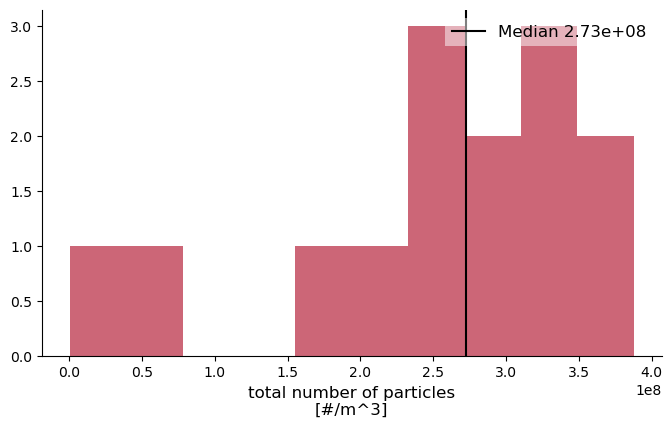

In [15]:
N_a = original_psd["particle_size_distribution"].sum(dim="radius")
N_a.attrs.update(
    long_name = "total number of particles",
    unit = "#/m^3",
    comment = "total number of particles per cubic meter of air",
    )
N_a.name = "N_a"
N_a.plot.hist()
N_a_median = N_a.median(dim="time").data
plt.axvline(
    N_a_median,
    label = f"Median {N_a_median:.2e}",
    color = "k",
)
plt.legend()

Because the distribution is normalized  to have sum 1, we need to make sure to use $PSD/N_a$ for the fitting.

In [16]:
input_psd = original_psd["particle_size_distribution"]

Prepare the input for the fitting

[2.72522848e+08 2.00000000e-06 3.00000000e+00]


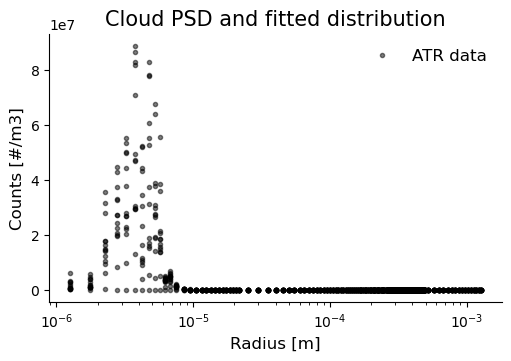

In [17]:

# extract diameter and counts from the data
x, y = x_y_flatten(input_psd, "radius")

# CONVERT THEM!
# TODO: This needs to be made sure of!
xdata = x # diameter to radius
ydata = y

# make sure no nans in the dataset
np.nan_to_num(xdata, copy=False, nan=0)
np.nan_to_num(ydata, copy=False, nan=0)

# Use some default uncertainties for the data.
# Tell the function, that 0 values are very uncertain.
sigma = ydata == 0
sigma = sigma.astype(float)
sigma = sigma * 1e5 + 1e-10

# # FIT THE DATA

fig, ax = plt.subplots(figsize=(5, 3.5), layout="constrained")

ax.plot(xdata, ydata, "k.", alpha=0.5, label="ATR data")
# ax.plot(radii, dist_cloud(radii), label="Fitted distribution")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Radius [m]")
ax.set_ylabel("Counts [#/m3]")
ax.set_title("Cloud PSD and fitted distribution")

fig.savefig(subfig_path / Path(f"fitting_psd.png"), dpi=300)

p0 = np.asarray([N_a_median, 2e-6, 3e0])
print(p0)

Give a first estimate of the fitting

nmodes = 1.00e+00
geomeans = [3.77e-06, ]
geosigs = [1.38e+00, ]
scalefacs = [2.73e+08, ]
numconc = 2.73e+08


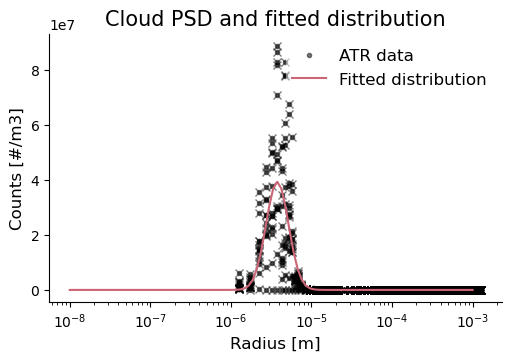

In [18]:

radii = np.logspace(-8, -3, 100)

dist_aerosol = probdists.LnNormal(
    geomeans             = [0.02e-6, 0.2e-6],
    geosigs              = [1.55, 2.3],             
    scalefacs            = [1e9, 0.3e9],
)

dist_cloud = probdists.LnNormal(
    geomeans = [1e0],
    geosigs =  [1e0],
    scalefacs = [1e0],
)

dist_cloud.fit_parameters(xdata, ydata, p0=p0, sigma=sigma)
dist_cloud.scalefacs = [N_a_median]
print(dist_cloud)

fig, ax = plt.subplots(figsize=(5, 3.5), layout="constrained")

ax.plot(xdata, ydata, "k.", alpha=0.5, label="ATR data")
ax.plot(original_psd.radius, original_psd["particle_size_distribution"], "kx", alpha=0.5)
ax.plot(radii, dist_cloud(radii) * np.sum(dist_cloud.scalefacs), label="Fitted distribution")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Radius [m]")
ax.set_ylabel("Counts [#/m3]")
ax.set_title("Cloud PSD and fitted distribution")

fig.savefig(subfig_path / Path(f"fitting_psd.png"), dpi=300)


In [19]:
# COMBINE THE DISTRIBUTIONS
dist_combined = dist_aerosol + dist_cloud
# ds_data = xr.Dataset(
#     data_vars = {
#         "particle_size_distribution" : ("radius", original_psd),
#     },
#     coords = {"radius" : xdata},
#     attrs = {
#         "name" : "atr",
#     },
# )

ds_combined = xr.Dataset(
    data_vars = {
        "particle_size_distribution" : ("radius", dist_combined(radii) * np.sum(dist_combined.scalefacs)
),
    },
    coords = {"radius" : radii},
    attrs = {
        "name" : "atr",
    },
)

ds_cloud = xr.Dataset(
    data_vars = {
        "particle_size_distribution" : ("radius", dist_cloud(radii) * np.sum(dist_cloud.scalefacs)
                                        ),
    },
    coords = {"radius" : radii},
    attrs = {
        "name" : "atr",
    },
)

ds_aerosol = xr.Dataset(
    data_vars = {
        "particle_size_distribution" : ("radius", dist_aerosol(radii) * np.sum(dist_aerosol.scalefacs)),
    },
    coords = {"radius" : radii},
    attrs = {
        "name" : "atr",
    },
)




def add_msd(ds) :
    ds["mass_size_distribution"] = msd_from_psd(
        ds=ds, 
        psd_name="particle_size_distribution",
        psd_factor=1e6,
        scale_name="radius",
        radius_given=True,
        scale_factor=1e0,
    )

add_msd(original_psd)
add_msd(ds_combined)
add_msd(ds_cloud)
add_msd(ds_aerosol)


/home/m/m301096/repositories/sdm-eurec4a/src/sdm_eurec4a/conversions.py:69: UserWarning: units is set to m^3/m^3. Make sure to check the units and otherwise set the value!
  warnings.warn("units is set to m^3/m^3. Make sure to check the units and otherwise set the value!")
/home/m/m301096/repositories/sdm-eurec4a/src/sdm_eurec4a/conversions.py:146: UserWarning: units is set to kg/m^3. Make sure to check the units and otherwise set the value!
  warnings.warn("units is set to kg/m^3. Make sure to check the units and otherwise set the value!")


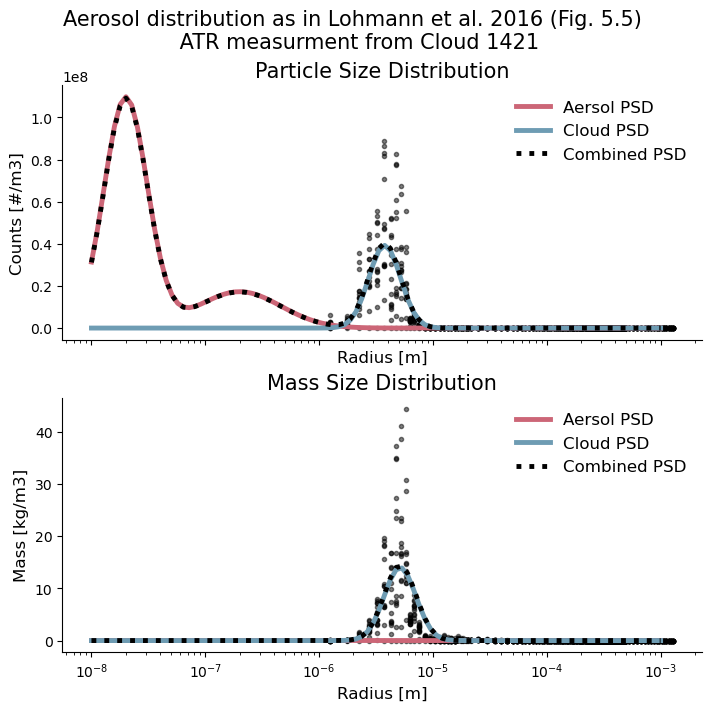

In [20]:
style = dict(
    linewidth = 3.5,
    alpha  = 1
)


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), layout="constrained", sharex=True)
ax_psd = axs[0]
ax_msd = axs[1]

for ax in axs.flatten():
    ax.set_xscale("log")
    ax.set_xlabel("Radius [m]")


ax_psd.plot(
    original_psd.radius,
    original_psd["particle_size_distribution"],
    linestyle = "none",
    marker = ".",
    color = "k",
    alpha = 0.5,
    )
ax_psd.plot(
    ds_aerosol.radius,
    ds_aerosol["particle_size_distribution"],
    label = f"Aersol PSD",
    **style
    )
ax_psd.plot(
    ds_cloud.radius,
    ds_cloud["particle_size_distribution"],
    label = f"Cloud PSD",
    **style
    )
ax_psd.plot(
    ds_combined.radius,
    ds_combined["particle_size_distribution"],
    label = f"Combined PSD",
    linestyle = ":",
    color = "k",
    **style
    )

ax_msd.plot(
    original_psd.radius,
    original_psd["mass_size_distribution"],
    linestyle = "none",
    marker = ".",
    color = "k",
    alpha = 0.5,
    )
ax_msd.plot(
    ds_aerosol.radius,
    ds_aerosol["mass_size_distribution"],
    label = f"Aersol PSD",
    **style
    )
ax_msd.plot(
    ds_cloud.radius,
    ds_cloud["mass_size_distribution"],
    label = f"Cloud PSD",
    **style
    )

ax_msd.plot(
    ds_combined.radius,
    ds_combined["mass_size_distribution"],
    label = f"Combined PSD",
    linestyle = ":",
    color = "k",
    **style
    )

ax_psd.set_ylabel("Counts [#/m3]")
ax_msd.set_ylabel("Mass [kg/m3]")
ax_psd.set_title("Particle Size Distribution")
ax_msd.set_title("Mass Size Distribution")

for ax in axs.flatten():
    ax.legend()

fig.suptitle(f"Aerosol distribution as in Lohmann et al. 2016 (Fig. 5.5) \n ATR measurment from Cloud {chosen_id}")
fig.savefig(subfig_path / Path(f"psd_msd_cloud_and_aerosol.png"), dpi=300)


In [21]:
print(dist_combined)

nmodes = 3.00e+00
geomeans = [2.00e-08, 2.00e-07, 3.77e-06, ]
geosigs = [1.55e+00, 2.30e+00, 1.38e+00, ]
scalefacs = [1.00e+09, 3.00e+08, 2.73e+08, ]
numconc = 1.57e+09
